#Using statsmodels tsa ExponentialSmoothing model

#Product_id = D_10006 Product_name = CURD - 200 G 

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns

In [100]:
df = pd.read_csv('Product_data.csv')

In [101]:
print(df.head())

     everyday productid                 productname  quantity
0  2023-08-16   D_10006                CURD - 200 G      60.0
1  2023-08-16   D_10029  STANDARDISED MILK - 500 ml      48.0
2  2023-08-16   D_10006                CURD - 200 G      60.0
3  2023-08-16   D_10017  DOUBLE TONED MILK - 500 ml      72.0
4  2023-08-16   D_10033         TONED MILK - 500 ml      24.0


In [102]:
df.shape

(2516944, 4)

In [103]:
# Cleaning the dataset
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
everyday       0
productid      0
productname    0
quantity       0
dtype: int64


In [104]:
# Check the data types of each column
print("\nData types:")
print(df.dtypes)


Data types:
everyday        object
productid       object
productname     object
quantity       float64
dtype: object


In [105]:
df.shape

(2516944, 4)

In [106]:
# Check the data types of each column
print("\nData types:")
print(df.dtypes)


Data types:
everyday        object
productid       object
productname     object
quantity       float64
dtype: object


In [107]:
# Filter for product ID D_10006
df_filtered = df[df['productid'] == 'D_10006']

# Group by date and sum quantity
df_grouped = df_filtered.groupby('everyday')['quantity'].sum().reset_index()

#everyday datatype changed into datetime
df_grouped['everyday'] = pd.to_datetime(df_grouped['everyday'])

In [108]:
print(df_grouped)

      everyday  quantity
0   2022-10-01    8760.0
1   2022-10-02    9720.0
2   2022-10-03   11820.0
3   2022-10-04   12720.0
4   2022-10-05   11880.0
..         ...       ...
319 2023-08-17    8580.0
320 2023-08-18    7380.0
321 2023-08-19    6720.0
322 2023-08-20    8100.0
323 2023-08-21    7860.0

[324 rows x 2 columns]


In [109]:
df_filtered.shape

(16024, 4)

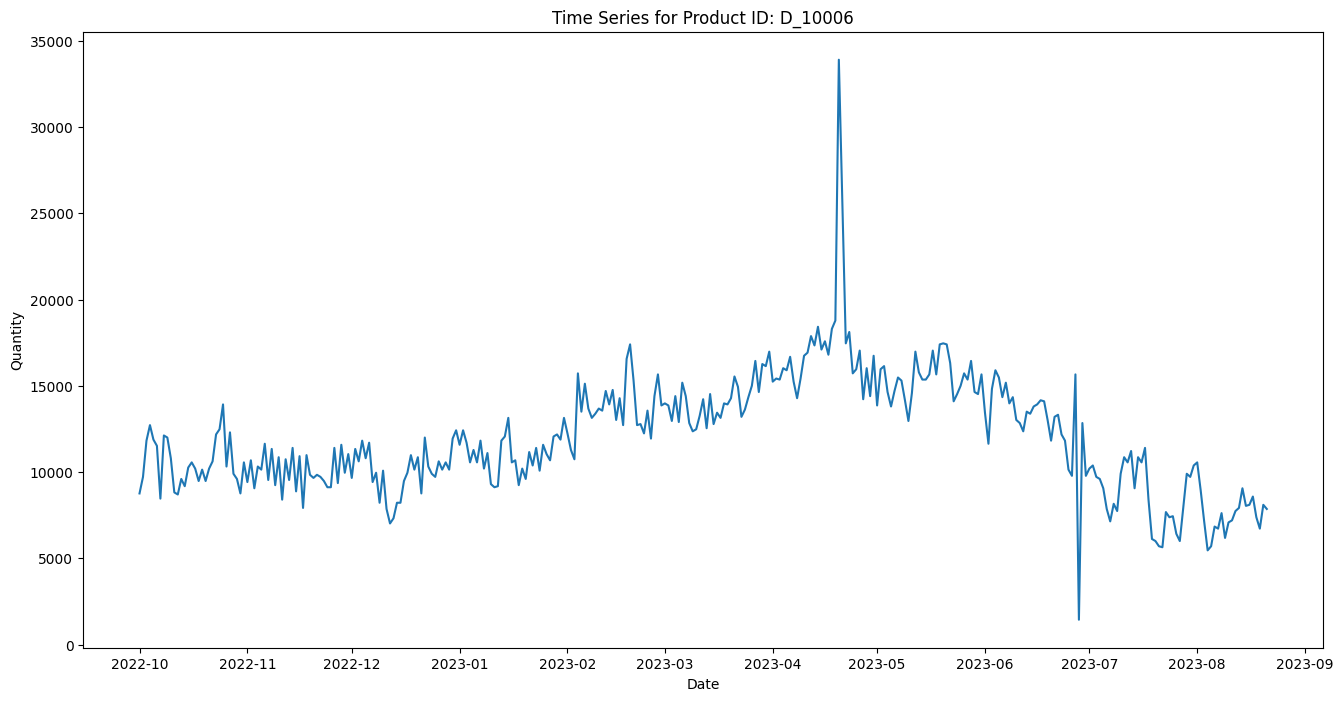

In [110]:
# Assuming df_product has columns 'date' and 'quantity'
plt.figure(figsize=(16, 8))
plt.plot(df_grouped['everyday'], df_grouped['quantity'])
plt.title(f'Time Series for Product ID: D_10006')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [111]:
df_grouped.shape

(324, 2)

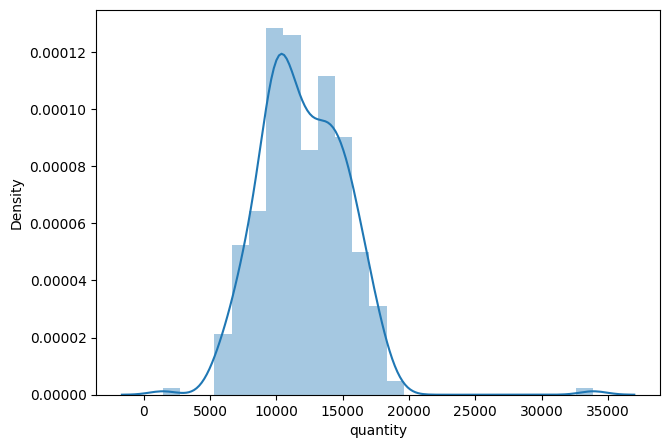

In [112]:
#detecting outlier in Quantity Columns Using Z Score Technique
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(df_grouped['quantity'])
plt.show()

In [113]:
df_grouped['quantity'].skew()

0.8555494440417836

In [114]:
print("Mean vlaue of Quantity", df_grouped['quantity'].mean())
print("Std vlaue of Quantity", df_grouped['quantity'].std())
print("Min vlaue of Quantity", df_grouped['quantity'].min())
print("Max vlaue of Quantity", df_grouped['quantity'].max())

Mean vlaue of Quantity 12007.962962962964
Std vlaue of Quantity 3266.491786772356
Min vlaue of Quantity 1440.0
Max vlaue of Quantity 33900.0


In [115]:
# Finding the boundary values
print("Highest allowed", df_grouped['quantity'].mean() + 3*df_grouped['quantity'].std())
print("Lowest allowed", df_grouped['quantity'].mean() - 3*df_grouped['quantity'].std())

Highest allowed 21807.438323280032
Lowest allowed 2208.487602645895


In [116]:
# Finding the outliers
df_grouped[(df_grouped['quantity'] > 21807.43) | (df_grouped['quantity'] < 2208.48)]

,everyday,quantity
201,2023-04-20,33900.0
269,2023-06-28,1440.0


Approach 1 Trimming

In [117]:
new_df = df_grouped[(df_grouped['quantity'] < 21807.43) & (df_grouped['quantity'] > 2208.48)]
new_df

,everyday,quantity
0,2022-10-01,8760.0
1,2022-10-02,9720.0
2,2022-10-03,11820.0
3,2022-10-04,12720.0
4,2022-10-05,11880.0
...,...,...
319,2023-08-17,8580.0
320,2023-08-18,7380.0
321,2023-08-19,6720.0
322,2023-08-20,8100.0


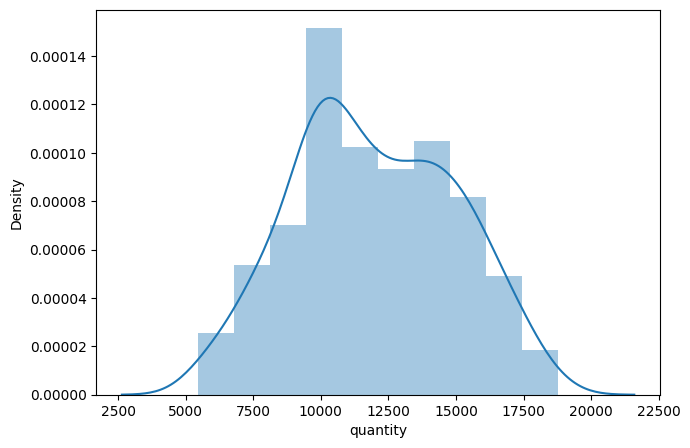

In [118]:
# Plot the time series data
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(new_df['quantity'])
plt.show()

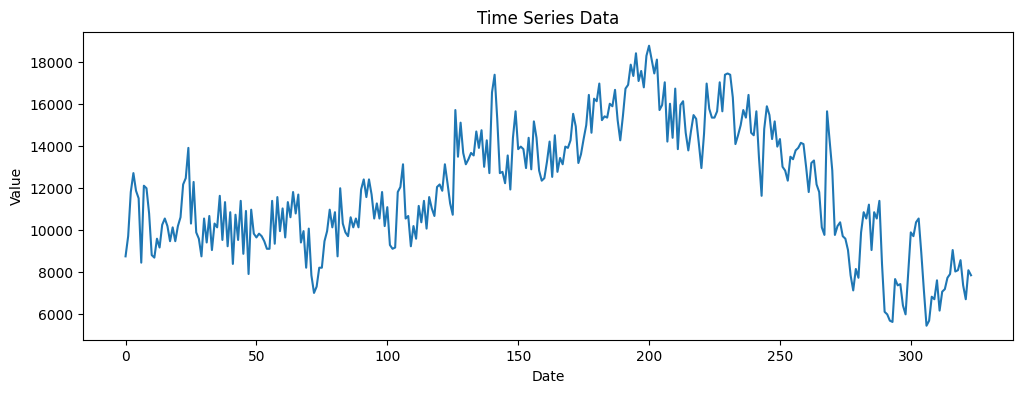

In [119]:
# Plot the time series data
plt.figure(figsize=(12, 4))
plt.plot(new_df['quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [120]:
# Try different period values based on assumed seasonality
periods_to_try = [7, 30, 60]  # Daily, monthly, yearly patterns

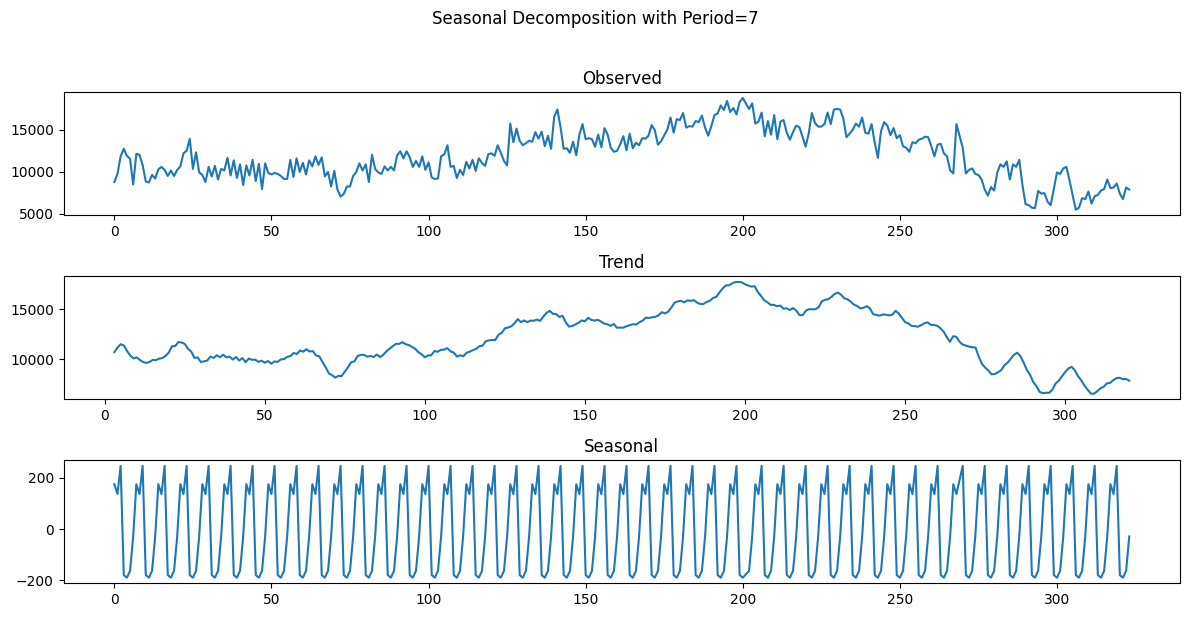

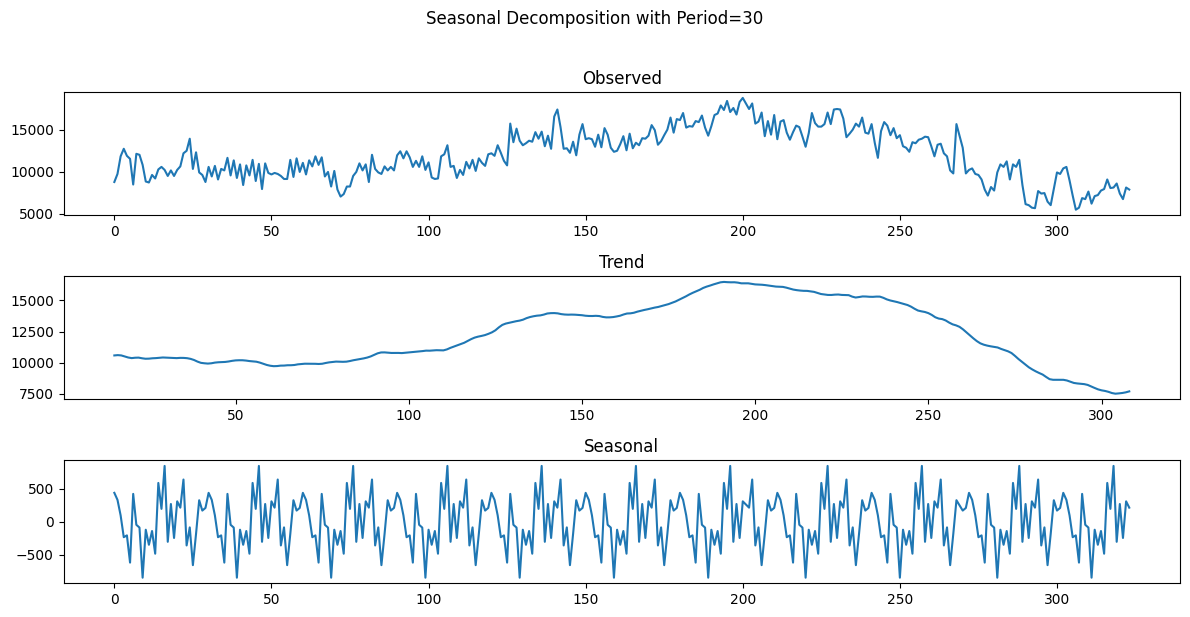

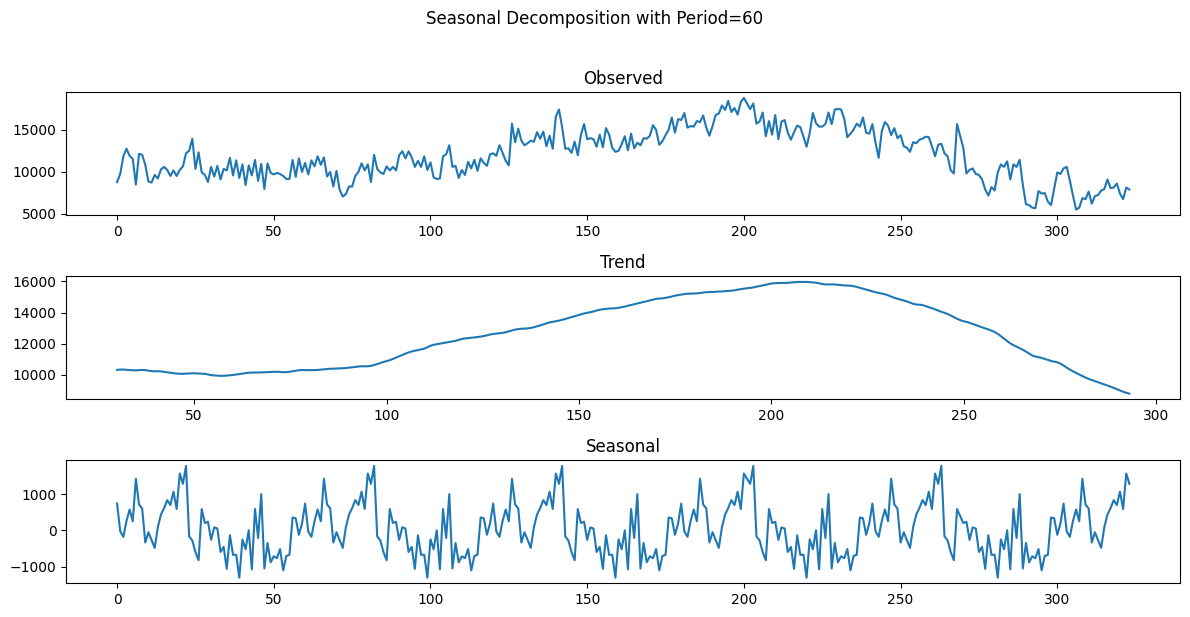

In [121]:
for period_value in periods_to_try:
    result = seasonal_decompose(new_df['quantity'], model='additive', period=period_value)
    
    # Plot the decomposed components
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Seasonal Decomposition with Period={period_value}', y=1.02)

    plt.subplot(3, 1, 1)
    plt.plot(result.observed)
    plt.title('Observed')

    plt.subplot(3, 1, 2)
    plt.plot(result.trend)
    plt.title('Trend')

    plt.subplot(3, 1, 3)
    plt.plot(result.seasonal)
    plt.title('Seasonal')

    plt.tight_layout()
    plt.show()

In [122]:
# Split data into training and testing sets 
train_size = int(len(new_df)*0.8) #80% of train data
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
# Fit ExpoentialSmoothing model
model = ExponentialSmoothing(train['quantity'], trend='mul', seasonal='mul', seasonal_periods=28)
model_fit = model.fit()

In [125]:
# Make predictions on the testing set
predication = model_fit.forecast(len(test))

In [126]:
# Evaluate model performance
mse = mean_squared_error(test['quantity'], predication)
print('Mean_Squared_Error:', mse)

Mean_Squared_Error: 10388939.805665908


In [127]:
# Forecast future values
future_forecast = model_fit.forecast(steps=3*30)
print('Future Forecast:\n', future_forecast)

Future Forecast:
 257    12827.960830
258    13167.174927
259    12795.276199
260    13060.519119
261    13657.019263
           ...     
342     9471.028718
343     9203.525358
344     9394.312170
345     9823.369278
346     9450.455717
Length: 90, dtype: float64


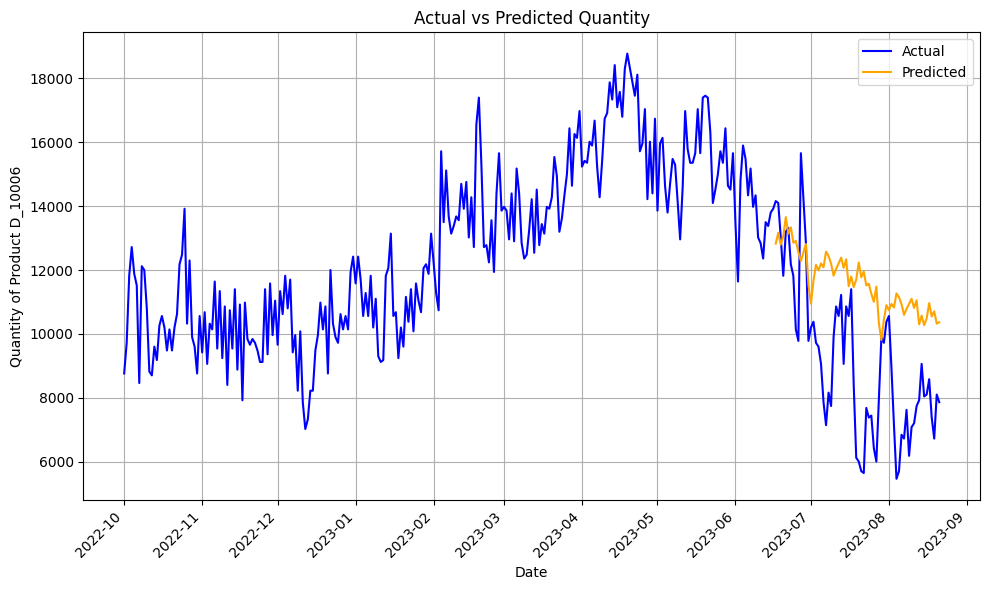

In [128]:
# Create the graph
plt.figure(figsize=(10, 6))

# Plot actual values (blue line)
plt.plot(new_df['everyday'], new_df['quantity'], label='Actual', color='blue')

# Plot predictions on the testing set (orange line)
plt.plot(test['everyday'], predication, label='Predicted', color='orange')

# Customize the graph
plt.xlabel('Date')
plt.ylabel('Quantity of Product D_10006')
plt.title('Actual vs Predicted Quantity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)

# Show the graph
plt.tight_layout()
plt.show()

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [130]:
model = ExponentialSmoothing(new_df['quantity'], trend='mul', seasonal='mul', seasonal_periods=150)

In [131]:
model_fit = model.fit()

In [132]:
# Check the data types of each column
print("\nData types:")
print(new_df.dtypes)


Data types:
everyday    datetime64[ns]
quantity           float64
dtype: object


In [133]:
# Step 3: Forecast future values
forecast = model_fit.forecast(steps=3*30)  # Forecasting for the next 3 months


In [134]:
new_df.tail()

,everyday,quantity
319,2023-08-17,8580.0
320,2023-08-18,7380.0
321,2023-08-19,6720.0
322,2023-08-20,8100.0
323,2023-08-21,7860.0


In [135]:
# Step 4: Print or use the forecast
print("Forecasted quantities for the next 3 months:")
print(forecast)

Forecasted quantities for the next 3 months:
322    7951.015554
323    7052.993370
324    7262.579436
325    7492.115864
326    7918.178653
          ...     
407    7739.269933
408    7769.500484
409    6722.304416
410    7320.652219
411    6963.119047
Length: 90, dtype: float64


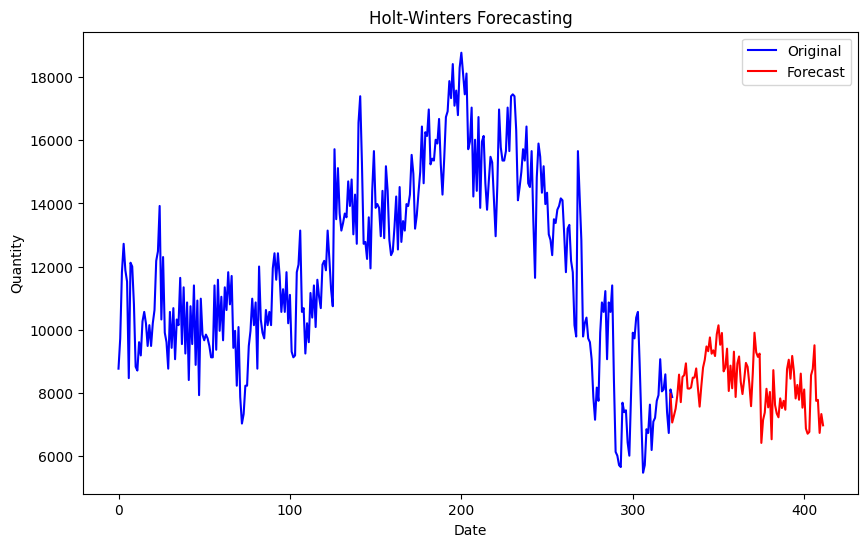

In [136]:
# Step 5: Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df['quantity'], label='Original', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [41]:
# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'date': forecast.index, 'forecast_quantity': forecast.values})

# Concatenate new_df with forecast_df
result_df = pd.concat([new_df, forecast_df.set_index('date')], axis=1)

# Print the resulting DataFrame
print(result_df)

      everyday  quantity  forecast_quantity
0   2022-10-01    8760.0                NaN
1   2022-10-02    9720.0                NaN
2   2022-10-03   11820.0                NaN
3   2022-10-04   12720.0                NaN
4   2022-10-05   11880.0                NaN
..         ...       ...                ...
407        NaT       NaN        7739.269933
408        NaT       NaN        7769.500484
409        NaT       NaN        6722.304416
410        NaT       NaN        7320.652219
411        NaT       NaN        6963.119047

[410 rows x 3 columns]


In [47]:
# Convert the DataFrame to CSV
result_df.to_csv('new_df_forecast.csv', index=False)

print("CSV file 'new_df_with_forecast.csv' has been created successfully.")

CSV file 'new_df_with_forecast.csv' has been created successfully.
